# A LITTLLE TRY TO PLOT GRAPH ON MAP

In [29]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Create visualisation where each airport is on the world map

https://towardsdatascience.com/catching-that-flight-visualizing-social-network-with-networkx-and-basemap-ce4a0d2eaea6

***
# Which part of the world is dominated by who, and what is a likely expansion?
***

## 1rst Part
Each airline has a country of origin, and we can also associate each airport to a country. We then start the analysis by identifying the major alliance for each airport (for each airport count the number of edges for each alliance and attribute the airport to the alliance with the maximum count). We then have a graph with 3 labels, and nodes with an unknown label, if not served by an alliance company. A validation step of this approach is then to see whether the country of the airport is the same as the country of one of the airlines inside the alliance (some countries have airlines belonging to different alliances, but that should not matter). When plotting the result on the worldmap, we might see geographic differences between the alliances.

### Loading data (from Nicolas Notebook)

In [2]:
# routes
routes = pd.read_csv('data/routes.dat', sep=',', encoding='utf-8')
routes.columns = ['Airline','AirlineID','SourceAirport','SourceAirportID','DestinationAirport','DestinationAirportID','Codeshare','Stops','Equipment']

# airlines
airlines = pd.read_csv('data/airlines.dat', sep=',', encoding='utf-8')
airlines.columns = ['AirlineID', 'Name', 'Alias',  'IATA', 'ICAO','Callsign','Country','Active']

# airports
airports = pd.read_csv('data/airports.dat', sep=',', encoding='utf-8')
airports.columns = ['AirportID', 'Name', 'City', 'Country', 'IATA', 'ICAO','Latitude','Longitude','Altitude', 'Timezone','DST', 'TzdatabaseTimeZone', 'Type', 'Source']

# alliances
alliances = pd.read_csv('data/alliances.dat', sep=',', encoding='utf-8')

### Creating the DataFrames corresponding to the work expected

In [3]:
# Airlines country DataFrame
airl_alliances  = pd.merge(alliances, airlines, left_on='Airline', right_on='Name', how = 'left')[['Alliance', 'Name', 'IATA', 'Country']]
# correct error of dataset
airl_alliances.loc[8].Country= 'Colombia'
airl_alliances.head()

,Alliance,Name,IATA,Country
0,Star Alliance,Adria Airways,JP,Slovenia
1,Star Alliance,Aegean Airlines,A3,Greece
2,Star Alliance,Air Canada,AC,Canada
3,Star Alliance,Air China,CA,China
4,Star Alliance,Air New Zealand,NZ,New Zealand


In [4]:
routes_alce = pd.merge(routes, airl_alliances, left_on = 'Airline', right_on = 'IATA', how = 'left')
routes_alce_only = routes_alce[~routes_alce.IATA.isnull()]
routes_alce_only.head(2)

,Airline,AirlineID,SourceAirport,SourceAirportID,DestinationAirport,DestinationAirportID,Codeshare,Stops,Equipment,Alliance,Name,IATA,Country
4237,A3,96,AOK,1459,ATH,3941,NaN,0,DH4,Star Alliance,Aegean Airlines,A3,Greece
4238,A3,96,AOK,1459,KSJ,1461,NaN,0,DH8,Star Alliance,Aegean Airlines,A3,Greece


### Plot world map with color according to airline country base

ColorCode :
- 1 if Star Alliance only
- 2 if One World only
- 3 if SkyTeam only
- 4 if Star Alliance and One World
- 5 if One World and SkyTeam
- 6 if SkyTeam and Star Alliance
- 7 if all

In [5]:
# For countries of airlines of alliances
country_attribution = pd.DataFrame(data={'Country': [], 'ColorCode': []});
for country in airl_alliances.Country.unique():
    alliances = airl_alliances[airl_alliances.Country==country].Alliance.unique()
    if 'Star Alliance' in alliances:
        if 'One World' in alliances:
            if 'SkyTeam' in alliances :
                colorCode = 7
            else :
                colorCode = 4
        elif 'SkyTeam' in alliances :
            coloCode = 6
        else :
            colorCode = 1
    elif 'One World' in alliances :
        if 'SkyTeam' in alliances :
            colorCode = 5
        else :
            colorCode = 2
    elif 'SkyTeam' in alliances :
        colorCode = 3
    country_attribution = country_attribution.append({'Country':country, 'ColorCode':colorCode},ignore_index=True)

country_attribution = country_attribution.set_index('Country')

#some change to fit the country names of world map
country_attribution.rename(index={'China':"People's Republic of China",
                                  'Republic of Korea': 'South Korea',
                                  #'Singapore':,
                                  'United States':'United States of America'},
                                  #'Hong Kong SAR of China':}, 
                                   inplace=True)




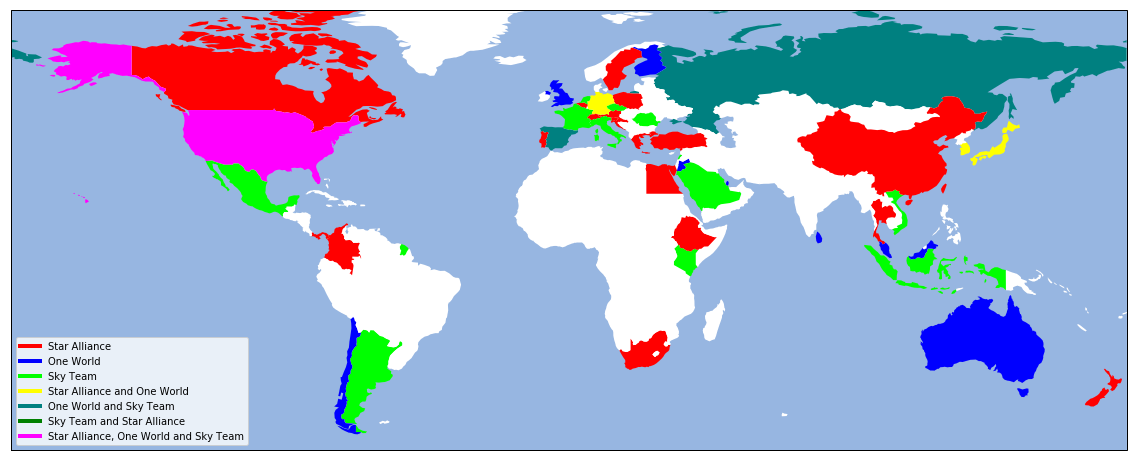

In [6]:
# plot world map
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs

plt.figure(figsize = (20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
#ax.add_feature(cartopy.feature.COASTLINE)
#ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
#ax.add_feature(cartopy.feature.LAKES, alpha=0.95)
#ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([-150, 60, -25, 60])

shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()


# 1 if Star Alliance only -> red
# 2 if One World only -> blue
# 3 if SkyTeam only -> green
# 4 if Star Alliance and One World
# 5 if One World and SkyTeam
# 6 if SkyTeam and Star Alliance
# 7 if all -> 
color_list=[(1,0,0),(0,0,1),(0,1,0),(1,1,0),(0,0.5,0.5),(0,0.5,0),(1,0,1)]

for country in countries:

    if country.attributes['NAME_EN'] in country_attribution.index :
        #print(country.attributes['NAME_EN'])
        num=country_attribution.loc[country.attributes['NAME_EN']].ColorCode-1
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor=color_list[int(num)],
                          label=country.attributes['NAME_EN'])
    else :
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor=(1,1,1),
                          label=country.attributes['NAME_EN'])
    
#plt.legend(color, ["SA", "OW", "ST", "SA+OW", "OW+ST", "ST+SA", "SA+OW+ST"])

#LEGEND
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

SA='Star Alliance'
OW='One World'
ST='Sky Team'
name_list=[SA, OW, ST, SA+' and '+OW, OW+' and '+ST, ST+" and "+SA, SA+', '+OW+' and '+ST]

legend_elements=[]
for i in range (0,7):
    legend_elements.append(Line2D([0], [0], color=color_list[i], lw=4, label=name_list[i]))
plt.legend(handles=legend_elements, loc='lower left')
plt.show()


Conclusion :  
- Each alliance is quite spread over the world : logical because they want to provide the best experience to their client (= they can go almost anywhere they want with this alliance)
- USA is an uncontournable country for alliance : it is a big country with a lot of client and it is not possible for any alliance to pass without it
- We can notice that several countries are "shared" between alliances -> what can we conclude on that ?

### Create airport "attribution"

In [7]:
# import of source and destination airport
source_airports = routes[['SourceAirport']]
source_airports = source_airports.rename(columns={'SourceAirport':'Airport'})

dest_airports = routes[['DestinationAirport']]
dest_airports = dest_airports.rename(columns={'DestinationAirport':'Airport'})

# creation of a dataframe with all airport and airport_idx 
# (we use airport_idx insteed of airportID because some airports have no airportID)
airportsID = pd.concat([source_airports,dest_airports]).drop_duplicates().reset_index().drop(columns=['index']).reset_index()
airportsID = airportsID.set_index('Airport').rename(columns={'index':'airportsID'})
airportsID.head(2)

,airportsID
Airport,
ASF,0
CEK,1


Creation of the weighted adjacency matrix. We first create a 3D tensor with dimensions {source, destination, alliance}. That way we can keep the weight intact for each flight.

No edges = 0  
No alliances = 1  
Star Alliance = 2  
One World = 3  
SkyTeam = 4  

In [8]:
# Create adjacency
routes_alce = routes_alce.fillna("None")
alliances_idx = {"None":1, "Star Alliance":2, "One World":3, "SkyTeam":4}
n_nodes = len(airportsID)
adjacency = np.zeros((n_nodes, n_nodes, 5), dtype=int)
for idx,row in routes_alce.iterrows():
    
    idx_source = airportsID.loc[row.SourceAirport, "airportsID"]
    idx_dest = airportsID.loc[row.DestinationAirport, "airportsID"]
    category = alliances_idx[row.Alliance]
    
    adjacency[idx_source, idx_dest, category] += 1
    adjacency[idx_dest, idx_source, category] += 1

In [9]:
# Go back to a DataFrame where each airport is attributed to an alliance
airport_attribution = airportsID.copy()
airport_attribution['Alliance'] = np.nan

for airport in airport_attribution.index :
    idx = int(airport_attribution.loc[airport].airportsID)
    SA = np.sum(adjacency[idx, :, 2]) + np.sum(adjacency[:, idx, 2])
    OW = np.sum(adjacency[idx, :, 3]) + np.sum(adjacency[:, idx, 3])
    ST = np.sum(adjacency[idx, :, 4]) + np.sum(adjacency[:, idx, 4])
    if SA==max(SA,OW,ST) :
        airport_attribution.loc[airport,'Alliance']="Star Alliance"
    elif OW==max(SA,OW,ST) :
        airport_attribution.loc[airport,'Alliance']="One World"
    elif ST==max(SA,OW,ST) :
        airport_attribution.loc[airport,'Alliance']="SkyTeam"

In [10]:
country_ref=airports[['Country','IATA']]
country_ref.rename(columns={"IATA": "Airport"},inplace=True)
country_ref.set_index('Airport', inplace=True)

airport_attribution = pd.merge(airport_attribution, country_ref,  on='Airport')
airport_attribution.drop(columns=['airportsID'], inplace=True)

C:\Users\maell\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [11]:
airport_attribution.head()

,Alliance,Country
Airport,,
ASF,Star Alliance,Russia
CEK,One World,Russia
DME,One World,Russia
EGO,Star Alliance,Russia
GYD,SkyTeam,Azerbaijan


# COMPARAISON BETWEEN THE TWO DISTRIBUTION

In [12]:
def compare(alliance, airport_attribution, country_attribution) :
    if alliance=='Star Alliance' :
        val=[1,4,6,7]
    elif alliance=='One World' :
        val=[2,4,5,7]
    elif alliance=='SkyTeam' :
        val=[3,5,6,7]
    else :
        print('The alliance parameter is not correct.')
        return
    
    print('Comparison between country and airport attribution for '+alliance)
    print()
    
    list1 = list(country_attribution[country_attribution['ColorCode'].isin(val)].index)
    print('Countries where the companies of the alliance have their basis :',len(list1))
    print(list1)
    print()
    
    list2 = list(airport_attribution[airport_attribution['Alliance']=='One World'].Country.unique())
    print('Countries where the alliance dominates airports :',len(list2))
    print(list2)
    print()
    
    inBoth=set(list1) & set(list2)
    print('Countries that are in both lists :',len(inBoth))
    print(inBoth)

### For Star Alliance

In [13]:
compare('Star Alliance',airport_attribution,country_attribution)

Comparison between country and airport attribution for Star Alliance

Countries where the companies of the alliance have their basis : 25
['Slovenia', 'Greece', 'Canada', "People's Republic of China", 'New Zealand', 'Japan', 'South Korea', 'Austria', 'Colombia', 'Belgium', 'Panama', 'Croatia', 'Egypt', 'Ethiopia', 'Taiwan', 'Poland', 'Germany', 'Sweden', 'Singapore', 'South Africa', 'Switzerland', 'Portugal', 'Thailand', 'Turkey', 'United States of America']

Countries where the alliance dominates airports : 81
['Russia', 'Peru', 'Ecuador', 'Italy', 'Spain', 'Finland', 'United Arab Emirates', 'Philippines', 'United States', 'United Kingdom', 'Australia', 'Hong Kong', 'Thailand', 'Malaysia', 'Germany', 'Austria', 'Bahamas', 'Morocco', 'Netherlands Antilles', 'Uzbekistan', 'Montenegro', 'Antigua and Barbuda', 'Dominica', 'Bangladesh', 'Oman', 'Mexico', 'Turkey', 'Greece', 'Brunei', 'Chile', 'India', 'Burma', 'Jamaica', 'Dominican Republic', 'Tajikistan', 'Argentina', 'Jordan', 'British V

### For One World

In [14]:
compare('One World',airport_attribution,country_attribution)

Comparison between country and airport attribution for One World

Countries where the companies of the alliance have their basis : 15
['Japan', 'South Korea', 'Germany', 'United States of America', 'Russia', 'Spain', 'United Kingdom', 'Hong Kong SAR of China', 'Finland', 'Chile', 'Malaysia', 'Australia', 'Qatar', 'Jordan', 'Sri Lanka']

Countries where the alliance dominates airports : 81
['Russia', 'Peru', 'Ecuador', 'Italy', 'Spain', 'Finland', 'United Arab Emirates', 'Philippines', 'United States', 'United Kingdom', 'Australia', 'Hong Kong', 'Thailand', 'Malaysia', 'Germany', 'Austria', 'Bahamas', 'Morocco', 'Netherlands Antilles', 'Uzbekistan', 'Montenegro', 'Antigua and Barbuda', 'Dominica', 'Bangladesh', 'Oman', 'Mexico', 'Turkey', 'Greece', 'Brunei', 'Chile', 'India', 'Burma', 'Jamaica', 'Dominican Republic', 'Tajikistan', 'Argentina', 'Jordan', 'British Virgin Islands', 'Puerto Rico', 'Virgin Islands', 'Turks and Caicos Islands', 'Colombia', 'Bahrain', 'Sri Lanka', 'Bolivia', '

### For SkyTeam

In [15]:
compare('SkyTeam',airport_attribution,country_attribution)

Comparison between country and airport attribution for SkyTeam

Countries where the companies of the alliance have their basis : 15
['United States of America', 'Russia', 'Argentina', 'Mexico', 'Spain', 'France', 'Italy', 'Czech Republic', 'Indonesia', 'Kenya', 'Netherlands', 'Lebanon', 'Saudi Arabia', 'Romania', 'Vietnam']

Countries where the alliance dominates airports : 81
['Russia', 'Peru', 'Ecuador', 'Italy', 'Spain', 'Finland', 'United Arab Emirates', 'Philippines', 'United States', 'United Kingdom', 'Australia', 'Hong Kong', 'Thailand', 'Malaysia', 'Germany', 'Austria', 'Bahamas', 'Morocco', 'Netherlands Antilles', 'Uzbekistan', 'Montenegro', 'Antigua and Barbuda', 'Dominica', 'Bangladesh', 'Oman', 'Mexico', 'Turkey', 'Greece', 'Brunei', 'Chile', 'India', 'Burma', 'Jamaica', 'Dominican Republic', 'Tajikistan', 'Argentina', 'Jordan', 'British Virgin Islands', 'Puerto Rico', 'Virgin Islands', 'Turks and Caicos Islands', 'Colombia', 'Bahrain', 'Sri Lanka', 'Bolivia', 'France', 'Be

## Conclusion

On one hand, we see that the countries where the alliances' airlines have their basis have a high probability to be on the countries where the alliance dominates some airports. It seems logical, because if an airline have it basis on a country, it will probably be a leader for the flights on this country, so the alliances dominates airports.  
On the over hand the countries where the alliance dominates some airport have a very high probability not to be a country where one of the airlines have it basis : it seems logicals because to expend the alliance and offer the best service to clients, it needs to 'controle' airports of countries that are not only basis of their companies.

## 2nd Part
We can study the expansion through transductive learning. In a first step we can unlabel some airports for which we know the major alliance serving it, and then through transductive learning, give labels to them and check the error. This can give an insight whether the current alliance status has an underlying network property. In a second step, through transductive learning, we can give labels to airports not served by an alliance airline. We could validate this step by checking airlines with country seat in the unlabelled airport countries (if there are any?) and see if between 2014 and now there were actual fusions or negotiations going on between these potential airlines and the alliances.

In [19]:
print('There is',len(airport_attribution),'airports where we know the major alliance')
print('So we can unlabeled 1/3 of those airports, that is corresponding to', len(airport_attribution)/3, 'airports')

There is 3185 airports where we know the major alliance
So we can unlabeled 1/3 of those airports, that is corresponding to 1061.6666666666667 airports


In [74]:
# select the airports to unlabel
list_airport = list(airport_attribution.index)
list_unknown_airport = random.sample(list_airport,1061)

# unlabel those airports
airport_to_label = airport_attribution[airport_attribution.index.isin(list_unknown_airport)]
airport_to_label['Alliance'] = 'None'

# create the reference for label propagation
airport_labeled = airport_attribution[~airport_attribution.index.isin(list_unknown_airport)]

C:\Users\maell\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [170]:
# propagate the labels, based on adjacency
def propagate_labels (airport_to_label, airport_labeled, adjacency, airportsID) :
    c=0;
    results = airport_to_label.copy()
    list_airport_to_label = list(airport_to_label.index)
    while list_airport_to_label != [] :
        # we randomly chose a point
        number_airport=len(list_airport_to_label)
        if number_airport>1:
            airport= list_airport_to_label[random.randint(0,number_airport-1)]
        else:
            airport= list_airport_to_label[0]
            
        # we count for all it neighbors
        idx = int(airportsID.loc[airport].airportsID)
        SA = np.sum(adjacency[idx, :, 2]) + np.sum(adjacency[:, idx, 2])
        OW = np.sum(adjacency[idx, :, 3]) + np.sum(adjacency[:, idx, 3])
        ST = np.sum(adjacency[idx, :, 4]) + np.sum(adjacency[:, idx, 4])
        
        # we attribute the label
        if SA==OW and OW==ST :
            results.loc[airport,'Alliance']="No Majority"
            c=c+1
#             if c>1000 : #stop algo
#                 return results
        elif SA==max(SA,OW,ST) :
            c=0
            results.loc[airport,'Alliance']="Star Alliance"
            list_airport_to_label.remove(airport)
        elif OW==max(SA,OW,ST) :
            c=0
            results.loc[airport,'Alliance']="One World"
            list_airport_to_label.remove(airport)
        elif ST==max(SA,OW,ST) :
            c=0
            results.loc[airport,'Alliance']="SkyTeam"
            list_airport_to_label.remove(airport)
            
    #return results
    return results

In [171]:
res = propagate_labels(airport_to_label, airport_labeled, adjacency, airportsID) 

KeyboardInterrupt: 

In [172]:
res.head()

,Alliance,Country
Airport,,
DME,One World,Russia
EGO,None,Russia
LED,SkyTeam,Russia
NBC,SkyTeam,Russia
UUA,None,Russia


In [176]:
airport_attribution.loc['UUA']

Alliance    Star Alliance
Country            Russia
Name: UUA, dtype: object